In [1]:
import argparse

import numpy as np
import torch
import torch.nn as nn
import fnmatch

from src.i3dpt import I3D

rgb_pt_checkpoint = 'model/model_rgb.pth'

## Set up the gpu and the model

In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER']="PCI_BUS_ID"
torch.cuda.set_device(0)
torch.cuda.current_device()
device = torch.device('cuda:0')

In [ ]:
if device.type == 'cuda':
    i = 0
    print(torch.cuda.get_device_name(i))
    print(torch.cuda.get_device_properties(i).total_memory)
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(i)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(i)/1024**3,1), 'GB')

In [164]:
torch.cuda.current_device()

0

In [5]:
i3d_rgb = I3D(num_classes=400, modality='rgb').to(device)

In [6]:
i3d_rgb.eval()
i3d_rgb.load_state_dict(torch.load(rgb_pt_checkpoint))

In [7]:
rgb_sample = np.load('data/kinetic-samples/v_CricketShot_g04_c01_rgb.npy').transpose(0, 4, 1, 2, 3)

In [8]:
sample_var = torch.autograd.Variable(torch.from_numpy(rgb_sample)).to(device)
print(sample_var.shape)
out_var, out_logit = i3d_rgb(sample_var)
print(out_var.shape)
out_tensor = out_var.data.cpu()

torch.Size([1, 3, 79, 224, 224])
torch.Size([1, 1024])


## Good to go, now test on sample data! 

### Extract i3d features

To be able to run this step:
1. Download the Kinetics dataset -> download.py
2. Extract the frames by ffmpeg -> extract_frames.py
3. Preprocess the frames and create npy files ->read_frames.py

In [15]:
rgb_sample = np.load("../ActivityNet/Crawler/Kinetics/mini_data_frames_rgb/abseiling__aQSjArgAqA_000123_000133.npy")
sample = torch.from_numpy(rgb_sample).unsqueeze(0)
print("shape now:", sample.shape)
sample_var = torch.autograd.Variable(sample).to(device)
print(sample_var.shape)
out_var, _ = i3d_rgb(sample_var)
print(out_var.shape)
out_tensor = out_var.data.cpu()

shape now: torch.Size([1, 3, 52, 224, 224])
torch.Size([1, 3, 52, 224, 224])
torch.Size([1, 1024])


In [16]:
sample_var = sample_var[:, :, :10, :, :]

In [17]:
i3d_rgb(sample_var)

(tensor([[0.1054, 0.0502, 0.1034,  ..., 0.1667, 0.0000, 0.0544]],
        device='cuda:0', grad_fn=<MeanBackward0>),
 tensor([[0.1054, 0.0502, 0.1034,  ..., 0.1667, 0.0000, 0.0544]],
        device='cuda:0', grad_fn=<MeanBackward0>))

In [9]:
frame_dir = "../ActivityNet/Crawler/Kinetics/mini_data_frames_rgb/"

In [ ]:
for dirpath, dirs, files in os.walk(frame_dir):
    for filename in fnmatch.filter(files, '*.npy'):
        print(filename)

In [18]:
vid_features = {}
vid_ids = []
for dirpath, dirs, files in os.walk(frame_dir):
    for filename in fnmatch.filter(files, '*.npy'):
        rgb_sample = np.load(dirpath+filename)
        sample = torch.from_numpy(rgb_sample).unsqueeze(0)
        if sample.shape[2] > 10: # should be bigger than the kernel size 
            vid_ids.append(filename)
            sample_var = torch.autograd.Variable(sample).to(device)
            try:
                out_var, _ = i3d_rgb(sample_var)
            except Exception as e: 
                print("error: ", e)
                print("   shape: ", sample_var.shape)
            vid_features[filename] = out_var.data.cpu().numpy()

### Extract word features

In [200]:
from argparse import ArgumentParser
import glob
import json
import os
import numpy as np
import torch
import re
import sys
import array

In [214]:
vectors = array.array('d')
print("Loading Glove Model")
gloveFile = '../glove.6B.300d.txt'
f = open(gloveFile, 'r', encoding="utf-8")
dct = {}
glove_model = {}
for i, line in enumerate(f):
    splitLine = line.split()
    word = splitLine[0]
    entries = splitLine[1:]
    embedding = np.array([float(val) for val in entries], dtype=np.float32)
    glove_model[word] = embedding
    dct[word] = i
    vectors.extend(float(x) for x in entries)

print("Done.", len(glove_model), " words loaded!")
#return model

Loading Glove Model
Done. 400000  words loaded!


In [206]:
#glove_model = loadGloveModel()

Loading Glove Model
Done. 400000  words loaded!


In [215]:
no_components = len(v)
no_vectors = len(dct)    
no_components = no_components
word_vectors = (np.array(vectors).reshape(no_vectors,no_components))
word_biases = np.zeros(no_vectors)
items_iterator = dct.items()
inverse_dictionary = {v: k for k, v in items_iterator}

In [ ]:
glove_model["hopscotch"]

In [217]:
def _similarity_query(word_vectors, word_vec, number, inverse_dictionary):
    
    dst = (np.dot(word_vectors, word_vec)
           / np.linalg.norm(word_vectors, axis=1)
           / np.linalg.norm(word_vec))
    word_ids = np.argsort(-dst)

    return [(inverse_dictionary[x], dst[x]) for x in word_ids[:number]
            if x in inverse_dictionary]

def most_similar(word_vectors, dictionary, word, number=5):
    """
    Run a similarity query, retrieving number
    most similar words.
    """

    if self.word_vectors is None:
        raise Exception('Model must be fit before querying')

    if self.dictionary is None:
        raise Exception('No word dictionary supplied')

    try:
        word_idx = dictionary[word]
    except KeyError:
        raise Exception('Word not in dictionary')

    return _similarity_query(word_vectors, word_vectors[word_idx], number, inverse_dictionary)[1:]

In [22]:
# should we use ing words?
word_dict = {
    'abseiling': glove_model['abseiling'],
    'air drumming': glove_model['drumming'],
    'answering questions': glove_model['answering'],
    'applauding': glove_model['applauding'],
    'applying cream': np.average([glove_model['applying'], glove_model['cream']], axis=0), # applying cream?
    'archery': glove_model['archery'], 
    'arm wrestling': np.average([glove_model['wrestling'], glove_model['arm']], axis=0), # arm wrestling
    'arranging flowers': np.average([glove_model['arranging'], glove_model['flowers']], axis=0), # arranging flowers
    'assembling computer': np.average([glove_model['assembling'], glove_model['computer']], axis=0), # assembling computer
    'auctioning': glove_model['auctioning'],
    'baby waking up': np.average([glove_model['baby'], glove_model['wakeup']], axis=0), # baby waking up
    'baking cookies': np.average([glove_model['baking'], glove_model['cookies']], axis=0), # baking cookies
    'balloon blowing': np.average([glove_model['balloon'], glove_model['blowing']], axis=0), 
    'bandaging': glove_model['bandaging'],
    'barbequing': glove_model['barbeque'],
    'bartending': glove_model['bartending'],
    'beatboxing': glove_model['beatboxing'],
    'bee keeping': glove_model['beekeeping'],
    'belly dancing': glove_model['bellydance'],
    'bench pressing': np.average([glove_model['weight'], glove_model['lifting']], axis=0) 
}

### Split train + test

In [25]:
print("Total videos:" , len(vid_ids))
print("total labels: ", len(word_dict.keys()))

Total videos: 785
total labels:  20


In [34]:
label_counter = {}
for v in vid_ids:
    label = v.split('_')[0]
    try:
        label_counter[label].append(v)
    except KeyError:
        label_counter[label] = [v]

In [112]:
import random
train_ids, val_ids, test_ids = [], [], []
for k, v in label_counter.items():
    p = len(v)* 20 // 100
    ind = random.sample(range(len(v)), p)
    val_ind = ind[:len(ind)//2]
    test_ind = ind[len(ind)//2:]
    for i, e in enumerate(v):
        if i in test_ind:
            test_ids.append(e)
        elif i in val_ind:
            val_ids.append(e)
        else:
            train_ids.append(e)

In [165]:
len(train_ids), len(val_ids), len(test_ids)

(639, 68, 78)

### Define dataset

In [387]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

class MultimodalDataset(Dataset):

    def __init__(self, train_ids, vids, words, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.train_ids = train_ids
        self.vids = vids
        self.caps = words

    def __len__(self):
        return len(self.train_ids)

    def __getitem__(self, idx):
        vid_id = self.train_ids[idx]
        vid_feat = self.vids[vid_id]
        word_feat = self.caps[vid_id.split('_')[0]]
        word_feat = np.expand_dims(word_feat, axis=0)
        label = vid_id.split("_")[0]

        sample = {'vid_feat': vid_feat, 'word_feat': word_feat, 'label':label}

        return sample

In [388]:
batch_size = 8
train_data = MultimodalDataset(train_ids, vids=vid_features, words=word_dict)
val_data = MultimodalDataset(val_ids, vids=vid_features, words=word_dict)
test_data = MultimodalDataset(test_ids, vids=vid_features, words=word_dict)
dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
dataloader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
dataloaders_dict = {
    'train' : DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True),
    'val': DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True),
    'test': DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
}

In [159]:
data_sample = train_data[10]
print(data_sample['vid_feat'].shape)
word = data_sample['word_feat']

(1, 1024)


In [160]:
test_data[0]['vid_feat'].shape

(1, 1024)

## Define simple model

In [169]:
class V2S(torch.nn.Module):

    def __init__(self,
                 video_dim,
                 latent_dim,
                 word_dim):
        super(V2S, self).__init__()

        self.fc1 = nn.Linear(video_dim, word_dim)
        #self.fc1 = nn.Linear(video_dim, latent_dim)
        #self.fc2 = nn.Linear(latent_dim, latent_dim)
        #self.fc3 = nn.Linear(latent_dim, word_dim)

    def forward(self, inp):
        out = self.fc1(inp)
        #out = self.fc2(out)
        #out = self.fc3(out)
        return out

In [352]:
import torch.nn.functional as F

# inspired from xu, corso et al
class V2S_nonlinear(torch.nn.Module):

    def __init__(self,
                 video_dim,
                 latent_dim,
                 word_dim):
        super(V2S_nonlinear, self).__init__()

        #self.fc1 = nn.Linear(video_dim, word_dim)
        self.fc1 = nn.Linear(video_dim, latent_dim)
        self.tanh = nn.Tanh()
        #self.fc2 = nn.Linear(latent_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim, word_dim)

    def forward(self, inp):
        out = self.fc1(inp)
        out = self.tanh(out)
        out = self.fc2(out)
        #out = self.fc3(out)
        return out

In [378]:
import copy

model = V2S(1024, 500, 300).to(device)

num_epochs=2000

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


import time
since = time.time()
model.train()

val_acc_history = []

best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 0.0

for epoch in range(num_epochs):

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval() 
        
        running_loss = 0.0
        running_corrects = 0
        optimizer.zero_grad()
        
        for data in dataloaders_dict[phase]:

            video = data["vid_feat"].float().to(device)
            word = data["word_feat"].float().to(device)

            #print(video.shape)
            #print(word.shape)
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(video)
                #print("prediction: ", y_pred.shape)
                # Compute and print loss
                loss = criterion(y_pred, word)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                        
            running_loss += loss.item() 
            #print(running_loss)
            #running_corrects += torch.sum(preds == labels.data)
        epoch_loss = running_loss #/ len(dataloaders_dict[phase].dataset)
        #loss = running_loss
        if phase == 'val':
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            val_acc_history.append(epoch_loss)
            if epoch%100 ==0:
                print(epoch_loss)
        
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best val Acc: {:4f}'.format(best_loss))

0.017086035517208716
0.012928592369836919
0.011981660828870885
0.01143557600238744
0.011123410042594461
0.011064204770852537
0.011011489173945259
0.010826056384864976
0.010884980397189365
0.010610780843040523
0.010835472384796423
0.0105829687022111
0.010431058923987782
0.010666219517588615
0.01042973469285404
0.01052871165687547
0.010580761686843984
0.010636583408888648
0.010507959927267888
0.010506123413934428
Training complete in 2m 57s
Best val Acc: 0.000000


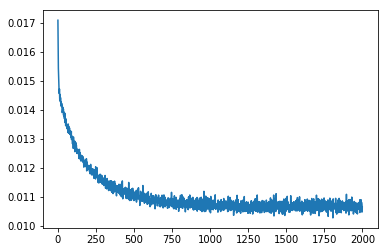

In [379]:
import matplotlib.pyplot as plt

plt.plot(val_acc_history)
plt.show()

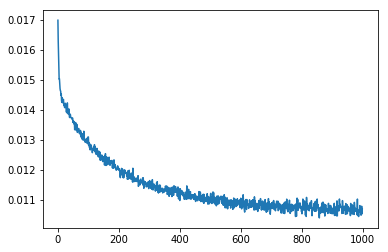

In [346]:
from copy import deepcopy
linear_acc = deepcopy(val_acc_history)
plt.plot(linear_acc)
plt.show()

### Evaluate on test data

In [380]:
model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)

eval_loss = []

for data in test_dataloader:
    video = data["vid_feat"].float().to(device)
    word = data["word_feat"].float().to(device)

    y_pred = model(video)
    loss = criterion(y_pred, word)
    eval_loss.append(loss.item())
    
print("val loss: ", np.mean(eval_loss))

val loss:  0.06829777508974075


## Check the most similar words

In [435]:
model.eval()

test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

eval_loss = []

similarities= {}
acc = 0
c = 0

for data in test_dataloader:
    video = data["vid_feat"].float().to(device)
    word = data["word_feat"].float().to(device)
    label = data["label"][0]

    y_pred = model(video)
    
    sample_word = y_pred.cpu().detach().numpy()
    sample_word = np.squeeze(np.transpose(sample_word))
    #print("samp word size:", label)
    sims = _similarity_query(word_vectors, sample_word, 10, inverse_dictionary)[1:]

    if label not in similarities:
        similarities[label] = [[sims]]
    else:
        similarities[label].append([sims])
    #label = "".join(label.split())
    #print(label)
    sim_words = [word_vals[0] for word_vals in sims]
    if check_match(label, sim_words):
        acc += 1
    c +=1

    loss = criterion(y_pred, word)
    eval_loss.append(loss.item())
    
print("val loss: ", np.mean(eval_loss))
print("total: ", c , " and acc: ", acc)

match! baby
val loss:  0.06848313064815906
total:  78  and acc:  1


In [438]:
print("total: ", c , " and acc: ", acc)

total:  78  and acc:  22


In [442]:
def check_match(key, sim_words):
    for w in sim_words:
        # Check direct match
        if sorted(list(w)) == sorted(list(k)):
            print("match!", w)
            return True
        # Check if any words of key is included in the similarities list
        for k_v in k.split(' '):
            #if sorted(list(w)) == sorted(list(k_v)):
            if str(w) == str(k_v):
                print("match!", w)
                return True
        # Check if concatenation of key is included 
        k_concat = ''.join(k.split(' '))
        if str(w) == str(k):
            print("match!", w)
            return True
    return False

In [443]:
for k, v in similarities.items():
    print("Key: ", k)
    for vals in v:
        sim_words = [word_vals[0] for word_vals in vals[0]]
        print(sim_words)
        if check_match(k, sim_words):
            acc += 1
    print(" =================================================== ")

Key:  bandaging
['baking', 'cooking', 'cakes', 'frying', 'butter', 'chocolate', 'cookies', 'honey', 'cheese']
['beatboxing', 'archery', 'bellydance', 'sword-fighting', 'applauding', 'clapping', 'butchering', 'horseriding', 'beekeeping']
['applauding', 'slapping', 'clapping', 'rubbing', 'weights', 'bandaging', 'auctioning', 'pulling', 'beatboxing']
match! bandaging
['bandages', 'dirce', 'bandage', 'deboning', 'pomade', 'in-hospital', 'suturing', '77.17', 'musluoglu']
Key:  belly dancing
['beatboxing', 'jiwamol', 'kanoksilp', 'tom.fowler@chron.com', 'bb95', 'el1l', 'technobabble', 'mangxamba', 'pi96']
['bartending', 'kusti', 'shadowboxing', 'el1l', 'free-style', 'division-i', 'crampon', 'charlatanism', 'hibachi']
['folksiness', 'ländler', 'tifo', 'rennweg', 'shadowboxing', 'overselling', 'enthusiam', 'goldsbury', 'reprocessors']
['archery', 'racquetball', 'ritualised', 'gymnastic', 'division-i', 'ländler', 'cardio', 'charlatanism', 'chhau']
Key:  balloon blowing
['baking', 'baby', 'cooki

21

## Check a data sample

In [242]:
print("real value: ", test_ids[0])

real value:  beatboxing_RtJ-HMpBko0_000007_000017.npy


In [191]:
test_video = torch.from_numpy(test_data[0]["vid_feat"]).float().to(device)
test_word = torch.from_numpy(test_data[0]["word_feat"]).float().to(device)

In [360]:
y_pred = model(test_video)

In [361]:
word_vector = y_pred.cpu().detach().numpy()
word_vector= np.squeeze(np.transpose(word_vector))

In [362]:
print("Closest words to prediction: ")
_similarity_query(word_vectors, word_vector, 10, inverse_dictionary)[1:]

Closest words to prediction: 


[('answering', 0.5228655202193893),
 ('composing', 0.44707119925323846),
 ('rapping', 0.4364975261342865),
 ('drumming', 0.43596508857237204),
 ('lecturing', 0.421478549577403),
 ('transcribing', 0.42125910532097677),
 ('improvising', 0.4190966266291168),
 ('beekeeping', 0.4182581283745773),
 ('synthesizing', 0.4066469140534339)]

In [239]:
word_vector_real = test_word.cpu().detach().numpy()
word_vector_real = np.squeeze(np.transpose(word_vector_real))

In [244]:
print("Closest words to real label")
_similarity_query(word_vectors, word_vector_real, 10, inverse_dictionary)[1:]

Closest words to real label


[('beatbox', 0.46125200363933017),
 ('rapping', 0.4035467694682134),
 ('microphotography', 0.39153406524065903),
 ('craniosacral', 0.3775974816350196),
 ('regulaciones', 0.37598784277196046),
 ('dj-ing', 0.3747132763941343),
 ('shito', 0.37439481270025377),
 ('visualisation', 0.37371987767263243),
 ('longform', 0.3714321225321916)]

## Unseen class word-embedding

### 1. Cricket Shot

In [444]:
sample_path = 'data/kinetic-samples/v_CricketShot_g04_c01_rgb.npy'
rgb_sample = np.load(sample_path).transpose(0, 4, 1, 2, 3)
sample = torch.from_numpy(rgb_sample)
print("shape now:", sample.shape)

shape now: torch.Size([1, 3, 79, 224, 224])


In [445]:
sample_var = torch.autograd.Variable(sample).to(device)
print(sample_var.shape)
out_var, _ = i3d_rgb(sample_var)

torch.Size([1, 3, 79, 224, 224])


In [446]:
out_var.shape

torch.Size([1, 1024])

In [447]:
sample_mapped = model(out_var)

In [448]:
sample_word = sample_mapped.cpu().detach().numpy()
sample_word = np.squeeze(np.transpose(sample_word))

In [449]:
_similarity_query(word_vectors, sample_word, 10, inverse_dictionary)[1:]

[('cheering', 0.47610855513611694),
 ('waving', 0.4578801978904351),
 ('shouting', 0.4318152041499119),
 ('jumping', 0.4139245687462716),
 ('blowing', 0.40986755690113463),
 ('loudly', 0.4072906243583767),
 ('yelling', 0.40108183295572564),
 ('waved', 0.3978462672313317),
 ('clapping', 0.3921057488450472)]

### 2. Drawing samples

In [458]:
unseen_frame_dir = "../ActivityNet/Crawler/Kinetics/unseen_mini_data_frames_rgb/"

In [459]:
unseen_vid_features = {}
unseen_vid_ids = []
for dirpath, dirs, files in os.walk(unseen_frame_dir):
    for filename in fnmatch.filter(files, '*.npy'):
        rgb_sample = np.load(dirpath+filename)
        sample = torch.from_numpy(rgb_sample).unsqueeze(0)
        if sample.shape[2] > 10: # should be bigger than the kernel size 
            unseen_vid_ids.append(filename)
            sample_var = torch.autograd.Variable(sample).to(device)
            try:
                out_var, _ = i3d_rgb(sample_var)
            except Exception as e: 
                print("error: ", e)
                print("   shape: ", sample_var.shape)
            unseen_vid_features[filename] = out_var.data.cpu().numpy()

In [306]:
label = unseen_vid_ids[150].split("_")[0]
label = label.split()
print(label)

['drinking', 'beer']


In [487]:
unseen_word_dict = {
    'drinking shots': np.average([glove_model['drinking'], glove_model['shots']], axis=0),
    'digging': glove_model['digging'],
    'drinking': glove_model['drinking'],
    'drawing': glove_model['drawing'],
    'drinking beer': np.average([glove_model['drinking'], glove_model['beer']], axis=0),
}

In [477]:
unseen_similarities= {}

unseen_loss=[]

for k, v in unseen_vid_features.items():
    #print(v.shape)
    var = torch.from_numpy(v).float().to(device)
    sample_mapped = model(var)
    sample_word = sample_mapped.cpu().detach().numpy()
    sample_word = np.squeeze(np.transpose(sample_word))
    #print("samp word size:", sample_word.shape )
    sims = _similarity_query(word_vectors, sample_word, 10, inverse_dictionary)[1:]
    
    label = k.split("_")[0]
    if label not in unseen_similarities:
        print("new label", label, "\n")
        unseen_similarities[label] = [[sims]]
    else:
        unseen_similarities[label].append([sims])
    
    word = unseen_word_dict[label]
    word = torch.from_numpy(word).float().to(device)
    loss = criterion(y_pred, word)
    unseen_loss.append(loss.item())

new label drinking shots 

new label drawing 

new label drinking 

new label drinking beer 

new label digging 



In [479]:
len(unseen_similarities.values())

5

In [480]:
acc = 0
c = 0
for k, v in unseen_similarities.items():
    print("Key: ", k)
    c +=1
    for vals in v:
        sim_words = [word_vals[0] for word_vals in vals[0]]
        print(sim_words)
        if check_match(k, sim_words):
            acc += 1
    print(" =================================================== ")

Key:  drinking shots
['waitressing', 'drumming', 'choreographing', 'babysitting', 'bartenders', 'clowning', 'caddying', 'fiddling', 'lecturing']
['singing', 'drummers', 'dancing', 'bartending', 'drum', 'drums', 'rapping', 'guitar', 'percussion']
['beatboxing', 'clapping', 'rapping', 'applauding', 'bartending', 'choreographing', 'clowning', 'strumming', 'dancing']
['drumming', 'drummers', 'djing', 'capoeira', 'clowning', 'choreographing', 'waitressing', 'dancing', 'strumming']
['rappelling', 'biking', 'parachuting', 'blacksmithing', 'wood-carving', 'kayaking', 'woodworking', 'climbing', 'beekeeping']
['drumming', 'beatboxing', 'abseiling', 'clowning', 'acrobatics', 'breakdancing', 'capoeira', 'choreographing', 'djing']
['bartending', 'mangxamba', 'prolixity', 'djing', 'drumming', 'carcase', 'freestyling', 'tom.fowler@chron.com', 'el1l']
['computers', 'computer', 'computerized', 'designing', 'machines', 'sewing', 'equipment', 'bellydance', 'answering']
['baking', 'cooking', 'cakes', 'coo